In [1]:
import numpy as np
from sklearn import datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import copy
from sklearn.linear_model import LinearRegression

In [2]:
#PLOT_PAIR = False
NUMERICAL =['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
TARGET = ['Species']
#test_split = .15
missing_ratio = .5

In [3]:
"""
Read data
"""
dfs = []
folder = './data'
for i in range(5):
    file = 'df' + str(i) + '.csv'
    dfs.append(pd.read_csv(folder + '/' + file))

In [4]:
def impute_column(df, col_to_predict, feature_columns):
  """ Imputar valores faltantes de una columna a partir de un
      modelo LR sobre columnas restantes
  """
  nan_rows = np.where(np.isnan(df[col_to_predict]))
  all_rows = np.arange(0,len(df))
  train_rows_idx = np.argwhere(~np.isin(all_rows,nan_rows)).ravel()
  pred_rows_idx =  np.argwhere(np.isin(all_rows,nan_rows)).ravel()

  X_train,y_train = df[feature_columns].iloc[train_rows_idx],df[col_to_predict].iloc[train_rows_idx]
  X_pred = df[feature_columns].iloc[pred_rows_idx]

  model = LinearRegression()
  model.fit(X_train, y_train)
  #df[col_to_predict].iloc[pred_rows_idx] = model.predict(X_pred.values.reshape(1,-1))
  #df[col_to_predict].iloc[pred_rows_idx] = model.predict(X_pred)
  df.loc[pred_rows_idx, col_to_predict] = model.predict(X_pred)
  return df

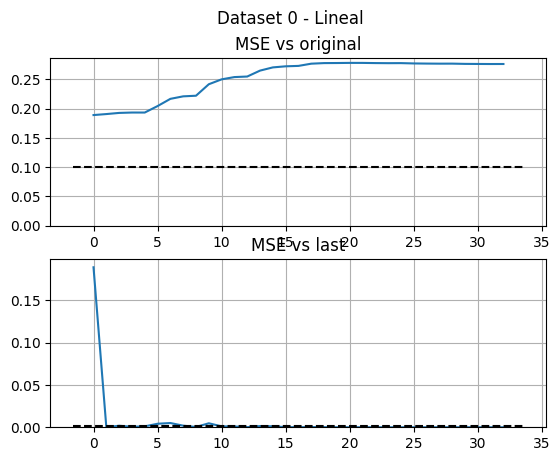

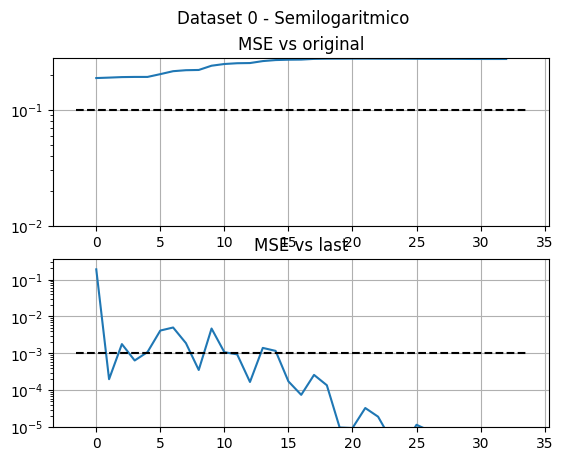

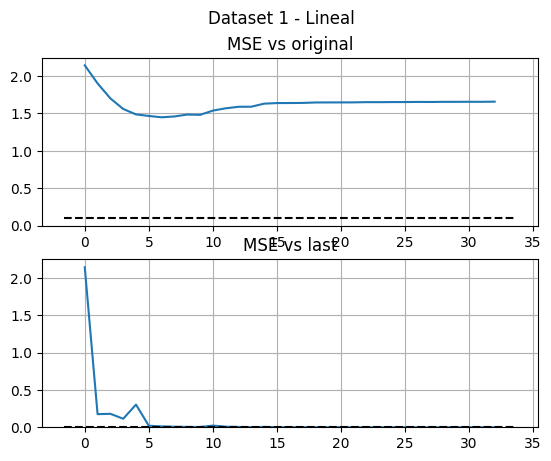

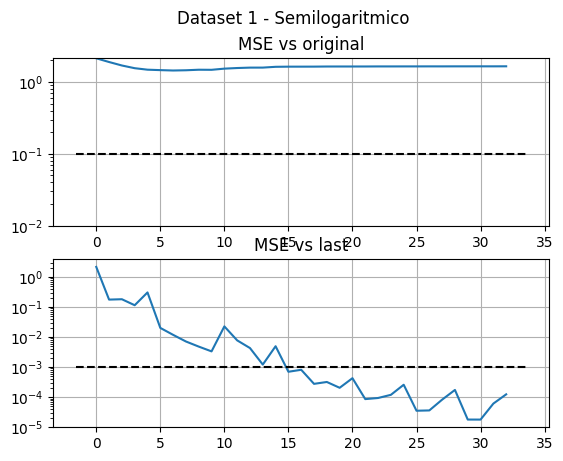

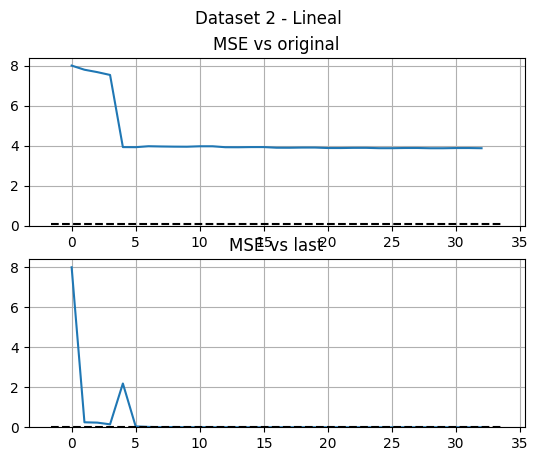

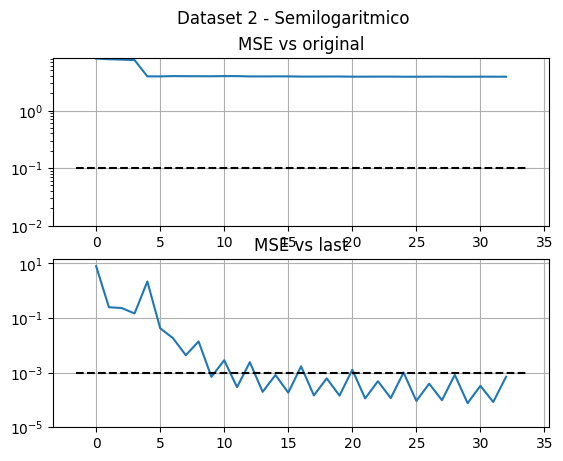

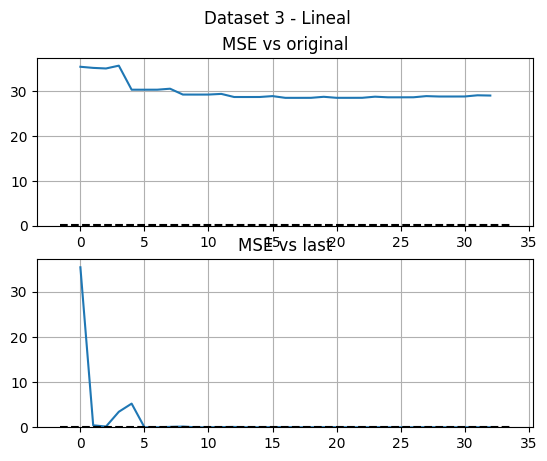

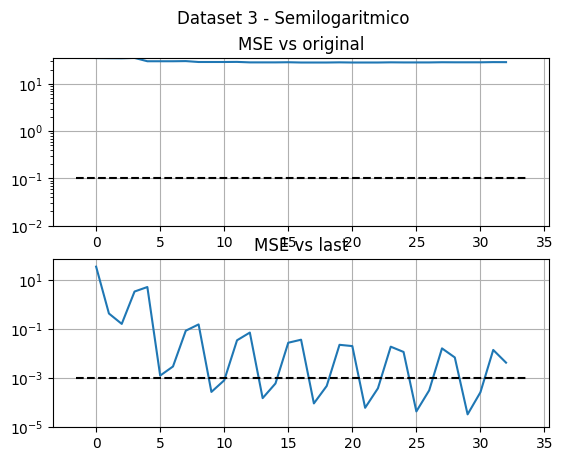

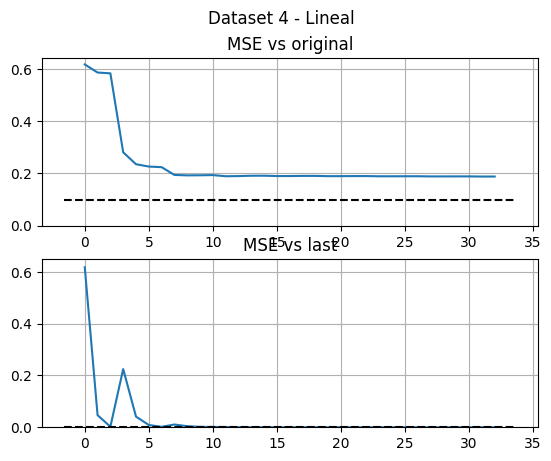

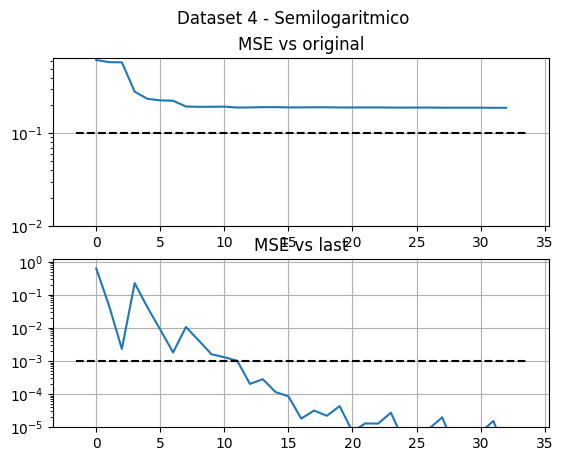

In [6]:
for df_idx,df in enumerate(dfs):

    """
    Data elimination
    """
    X = df[NUMERICAL] 
    y = df[TARGET]
    X_missing = []
    mask = np.random.choice(a=[np.nan, 1.0], size=X.shape, p=[missing_ratio,1-missing_ratio])
    X_missing = X * mask




    """
    MICE step by step
    """
    df_orig    = pd.DataFrame(X)
    df_missing = pd.DataFrame(X_missing)
    df_0 = df_missing.copy()
    for col in NUMERICAL:
        df_0.loc[df_0[col].isna(),col] = df_0[col].mean()
    dfs = [df_0,]
    mses_vs_last = [np.mean((df_0-df_orig)**2)]
    mses_vs_orig = [np.mean((df_0-df_orig)**2)]
    for step in range(0,8):
        for col in NUMERICAL:
            tmp_feature_cols = copy(NUMERICAL)
            tmp_feature_cols.remove(col)
            df_last = dfs[-1]
            df_aux = df_last.copy()
            df_aux.loc[df_missing[col].isna(),col] = np.nan
            df_imputed = impute_column(df_aux, col, tmp_feature_cols)
            dfs.append(df_imputed)
            mses_vs_last.append(np.mean((df_imputed-df_last)**2))
            mses_vs_orig.append(np.mean((df_imputed-df_orig)**2))

    fig, axs = plt.subplots(2,1)
    fig.suptitle(f'Dataset {df_idx} - Lineal')
    axs[0].plot(mses_vs_orig)
    axs[0].title.set_text('MSE vs original')
    axs[1].plot(mses_vs_last)
    axs[1].title.set_text('MSE vs last')
    xlim = axs[0].get_xlim()
    axs[0].hlines(0.1, xmin=xlim[0], xmax=xlim[1], color='black', linestyle='dashed')
    xlim = axs[1].get_xlim()
    axs[1].hlines(0.001, xmin=xlim[0], xmax=xlim[1], color='black', linestyle='dashed')
    axs[0].set_ylim(0, None)
    axs[1].set_ylim(0, None)
    axs[0].grid()
    axs[1].grid()

    fig, axs = plt.subplots(2,1)
    fig.suptitle(f'Dataset {df_idx} - Semilogaritmico')
    axs[0].semilogy(mses_vs_orig)
    axs[0].title.set_text('MSE vs original')
    axs[1].semilogy(mses_vs_last)
    axs[1].title.set_text('MSE vs last')
    xlim = axs[0].get_xlim()
    axs[0].hlines(0.1, xmin=xlim[0], xmax=xlim[1], color='black', linestyle='dashed')
    xlim = axs[1].get_xlim()
    axs[1].hlines(0.001, xmin=xlim[0], xmax=xlim[1], color='black', linestyle='dashed')
    axs[0].set_ylim(1e-2, None)
    axs[1].set_ylim(1e-5, None)
    axs[0].grid()
    axs[1].grid()

plt.show()